In [1]:
import matplotlib
rc_fonts = {
    "font.size": 14,
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3dexp.db

from utils import get_by_expnames, get_by_ext, pretty

In [2]:
# dataset = 'jpeg/flickr50k'
num_workers=8
hostname='cloudlet029'

df_all = pd.read_sql(
    'SELECT expname, basedir, avg_wall_ms, (1 / avg_wall_ms * 1000) as throughput, num_workers, avg_mbyteps as bandwidth, avg_cpu_ms FROM EurekaExp \
        WHERE expname LIKE %s AND hostname=%s AND num_workers=%s ORDER BY expname',
    s3dexp.db.engine,
    params=["macro-%", hostname, num_workers])


# temp hack as I haven't finished rerunning all exps on c29
# df_all = pd.concat(
#     [
#         pd.read_sql(
#             'SELECT expname, basedir, avg_wall_ms, (1 / avg_wall_ms * 1000) as throughput, num_workers, avg_mbyteps as bandwidth, avg_cpu_ms FROM EurekaExp \
#                 WHERE expname LIKE %s AND hostname=%s AND num_workers=%s ORDER BY expname',
#             s3dexp.db.engine,
#             params=["macro-redbus%", 'cloudlet029', num_workers]),
#         pd.read_sql(
#             'SELECT expname, basedir, avg_wall_ms, (1 / avg_wall_ms * 1000) as throughput, num_workers, avg_mbyteps as bandwidth, avg_cpu_ms FROM EurekaExp \
#                 WHERE expname LIKE %s AND hostname=%s AND num_workers=%s ORDER BY expname',
#             s3dexp.db.engine,
#             params=["macro-obama%", 'cloudlet029', num_workers]),
#         pd.read_sql(
#             'SELECT expname, basedir, avg_wall_ms, (1 / avg_wall_ms * 1000) as throughput, num_workers, avg_mbyteps as bandwidth, avg_cpu_ms FROM EurekaExp \
#                 WHERE expname LIKE %s AND hostname=%s AND num_workers=%s ORDER BY expname',
#             s3dexp.db.engine,
#             params=["macro-pedestrian%", 'cloudlet027', num_workers])
#     ],
#     ignore_index=True
# )
        


df_all

,expname,basedir,avg_wall_ms,throughput,num_workers,bandwidth,avg_cpu_ms
0,macro-obama-hdd,/mnt/hdd/fast20/jpeg/flickr50k,89.214321,11.208963,8,0.844294,711.692666
1,macro-obama-smart,/mnt/hdd/fast20/jpeg/flickr50k,33.421192,29.921135,8,0.630724,172.481330
2,macro-obama-ssd,/mnt/ssd/fast20/jpeg/flickr50k,88.419002,11.309786,8,0.851888,705.763369
3,macro-pedestrian10-hdd,/mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,3.575583,279.674689,8,9.702833,8.365851
4,macro-pedestrian10-smart,/mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,2.714721,368.361988,8,101.866582,1.689726
5,macro-pedestrian10-ssd,/mnt/ssd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,2.943774,339.700044,8,11.785309,8.388024
6,macro-pedestrian50-hdd,/mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,7.236989,138.179008,8,4.793883,16.242605
7,macro-pedestrian50-smart,/mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,6.771569,147.676257,8,204.191476,9.050976
8,macro-pedestrian50-ssd,/mnt/ssd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,7.504120,133.260133,8,4.623231,16.221611
9,macro-redbus-hdd,/mnt/hdd/fast20/jpeg/flickr50k,3.881150,257.655624,8,19.407424,8.760106


## HDD vs SSD vs Ours

In [3]:
workloads = ['redbus', 'redbusclass', 'obama', 'pedestrian10', 'pedestrian50']

devices = ['hdd', 'ssd', 'smart']
device_names = ['HDD', 'SSD', 'Decode-Enabled Storage']
colors = ['tab:gray', 'tab:blue', 'tab:red']

In [4]:
%matplotlib notebook

def plot_macro(col = 'throughput', ylabel = 'Images / s', savefig_path = 'macro-throughput.pdf', ymax=None):
    plt.figure(figsize=(6.5,3.5))

    ind = np.arange(len(workloads))
    width = 0.3       

    for i, (dev, dev_name, c) in enumerate(zip(devices, device_names, colors)):
        df = get_by_expnames(df_all, ['macro-{}-{}'.format(w, dev) for w in workloads])

        x, y = ind + i*width, df[col]
        plt.bar(x, y, width, label=dev_name, color=c)
        
        # clip y in case y > ymax
        if ymax:
            y = np.minimum(y, ymax)
        
        if col == 'throughput' and dev != 'hdd':
            # annotate speed-up
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y / df_hdd['throughput']):
                plt.annotate('{:.1f}x'.format(s1), (x1 - width*.5, y1 + 30))
                
        if col == 'avg_cpu_ms' and dev != 'hdd':
            # annotate saving of CPU time
            print "annotating CPU time saving"
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y / df_hdd['avg_cpu_ms']):
                print x1, y1, s1
                plt.annotate('{:4.0f}\%'.format(s1*100), (x1 - width*.8, y1 + 1))
            


#     plt.ylabel(ylabel)
    plt.ylim(None, ymax)
    plt.xticks(ind + width, map(pretty, workloads), rotation=20)
    plt.legend(bbox_to_anchor=(.5, 1), loc='lower center', ncol=len(ind))
    # plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig(savefig_path, bbox_inches ='tight')

    plt.show()

<IPython.core.display.Javascript object>


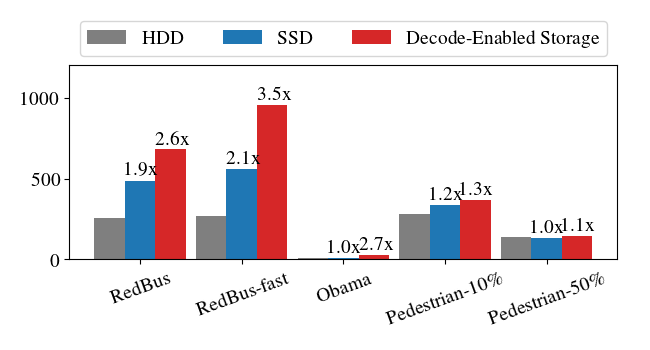

/home/zf/miniconda2/envs/s3dexp/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [5]:
plot_macro('throughput', 'Images / s', savefig_path='macro-throughput.pdf', ymax=1200)
# plot_macro('bandwidth', 'MByte / s', savefig_path= 'macro-bandwidth.pdf')
# plot_macro('avg_cpu_ms', 'Millisecond / Image', savefig_path = 'macro-cputime.pdf', ymax=20)

## Broken-Y Plot for Obama CPU Time

<IPython.core.display.Javascript object>


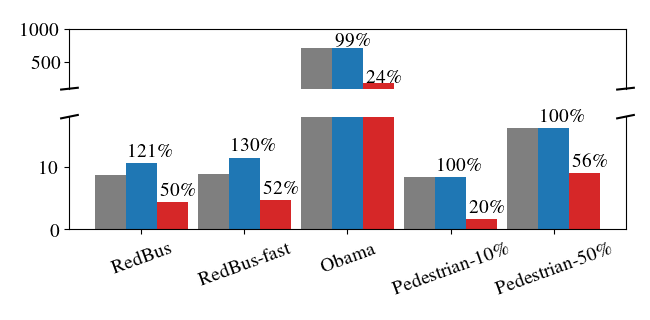

annotating CPU time saving
0.3 10.556203974 1.20503155789
1.3 11.4733743112 1.29573569118
2.3 705.763369275 0.991668739741
3.3 8.38802361022 1.00265034052
4.3 16.2216108607 0.998707473935
annotating CPU time saving
0.6 4.35259592329 0.496865678156
1.6 4.64463819155 0.524538232101
2.6 172.48132989 0.24235367049
3.6 1.68972590685 0.2019789565
4.6 9.05097596051 0.557236726722
annotating CPU time saving
0.3 10.556203974 1.20503155789
1.3 11.4733743112 1.29573569118
2.3 18.0 0.0252918160568
3.3 8.38802361022 1.00265034052
4.3 16.2216108607 0.998707473935
annotating CPU time saving
0.6 4.35259592329 0.496865678156
1.6 4.64463819155 0.524538232101
2.6 18.0 0.0252918160568
3.6 1.68972590685 0.2019789565
4.6 9.05097596051 0.557236726722


/home/zf/miniconda2/envs/s3dexp/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [6]:
%matplotlib notebook

col = 'avg_cpu_ms'
ylabel = 'CPU ms / Image'

UPPER_YMAX = 1000
UPPER_YMIN = 90
LOWER_YMAX = 18

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6.5, 3.2), gridspec_kw={'height_ratios': [1.6, 3]})

for ax in (ax1, ax2):
    ind = np.arange(len(workloads))
    width = 0.3       

    for i, (dev, dev_name, c) in enumerate(zip(devices, device_names, colors)):
        df = get_by_expnames(df_all, ['macro-{}-{}'.format(w, dev) for w in workloads])

        x, y = ind + i*width, df[col]
        
        # clip lower plot's y
        if ax is ax2:
            y = np.minimum(LOWER_YMAX, y)
        
        ax.bar(x, y, width, label=dev_name, color=c)
        
        if col == 'avg_cpu_ms' and dev != 'hdd':
            # annotate saving of CPU time
            print "annotating CPU time saving"
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y / df_hdd['avg_cpu_ms']):
                print x1, y1, s1
                ax.annotate('{:4.0f}\%'.format(s1*100), (x1 - width*.4, y1 + (10 if ax is ax1 else 1)))

# upper subplot
ax1.set_ylim(UPPER_YMIN, UPPER_YMAX)
ax1.spines['bottom'].set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off', top=False, bottom=False)

# lower subplot
ax2.set_ylim(None, LOWER_YMAX)
ax2.spines['top'].set_visible(False)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    
# plt.ylabel(ylabel)
# ax2.yaxis.set_label_coords(-.05,1)

plt.xticks(ind + width, map(pretty, workloads), rotation=20)
# plt.legend(bbox_to_anchor=(.5, 1), loc='lower center', ncol=len(ind))
# plt.legend(loc='best')

plt.tight_layout()
plt.savefig('macro-cputime-brokeny.pdf', bbox_inches ='tight')

plt.show()

In [ ]:
%matplotlib notebook

def plot_macro_relative(col = 'throughput', ylabel = 'Images / s', savefig_path = 'macro-throughput.pdf', 
                        ymax=None, fn = lambda y0,y: np.divide(y, y0)):
    
    plt.figure(figsize=(6,3))

    ind = np.arange(len(workloads))
    width = 0.25       
    
    df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
    print df_hdd
    
    for i, (dev, dev_name, c) in enumerate(zip(devices, device_names, colors)):
        df = get_by_expnames(df_all, ['macro-{}-{}'.format(w, dev) for w in workloads])
#         print df

        x, y = ind + i*width, fn(df_hdd[col].values, df[col].values)
        
        print "x=", x, "y=", y
        
        plt.bar(x, y, width, label=dev_name, color=c)
        
        # clip y in case y > ymax
        if ymax:
            y = np.minimum(y, ymax)
        
        if col == 'throughput' and dev != 'hdd':
            # annotate speed-up
            for x1, y1, s1 in zip(x, y, y):
                plt.annotate('{:.1f}x'.format(s1), (x1 - width*.4, y1 + .1))
                
        if col == 'avg_cpu_ms' and dev != 'hdd':
            # annotate saving of CPU time
            print "annotating CPU time saving"
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y):
                print x1, y1, s1
                plt.annotate('{:4.0f}\%'.format(s1*100), (x1 - width*.4, y1 + .1))
            


    plt.ylabel(ylabel)
    plt.ylim(None, ymax)
    plt.xticks(ind + width, map(pretty, workloads))
    plt.legend(bbox_to_anchor=(.5, 1), loc='lower center', ncol=len(ind))
    # plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig(savefig_path, bbox_inches ='tight')

    plt.show()

plot_macro_relative('throughput', 'Relative Throughput', savefig_path='macro-throughput-relative.pdf', ymax=2.5)
plot_macro_relative('avg_cpu_ms', 'Relative CPU Time / Image', savefig_path='macro-cputime-relative.pdf', ymax=1.5, fn=lambda y0,y: y/y0)
